(160, 320, 3)


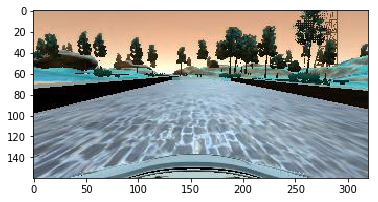

(70, 320, 3)


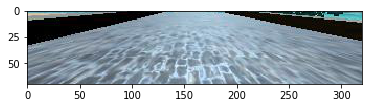

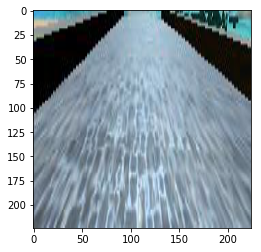

[[[ 84 178 224]
  [ 77 171 217]]

 [[ 84 178 224]
  [ 77 171 217]]]
[[[-0.17058824  0.19803922  0.37843137]
  [-0.19803922  0.17058824  0.35098039]]

 [[-0.17058824  0.19803922  0.37843137]
  [-0.19803922  0.17058824  0.35098039]]]


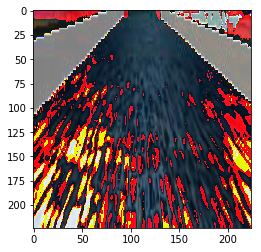

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

name = './data/IMG/center_2016_12_01_13_30_48_287.jpg'
image = cv2.imread(name)
print(np.shape(image))
plt.imshow(image)
plt.show()

image = image[65:135, 0:320]
print(np.shape(image))
plt.imshow(image)
plt.show()

image = cv2.resize(image, (224, 224))
plt.imshow(image)
plt.show()

print(image[:2,:2])
image = image / 255.0 - 0.5
print(image[:2,:2])
plt.imshow(image)
plt.show()

In [13]:
############################################################################
# Get bottleneck features of ResNet50
############################################################################
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import logging
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras import applications

logger = logging.getLogger()
logger.setLevel(logging.INFO) #logging.INFO logging.DEBUG
if logger.handlers == []:
    ch = logging.StreamHandler()
    logger.addHandler(ch)

# Load training data (image file name + steering) from csv file
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if line[0] == 'center':  # exclude the header line
            continue
        samples.append(line)

# Split 20% data as validation samples
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
logger.info('number of training samples {}'.format(len(train_samples)))
logger.info('number of validation samples {}'.format(len(validation_samples)))

# Define variables for bottleneck feature generator
y_train = []
y_validation = []
batch_size = 64
train_steps = len(train_samples) // batch_size
validation_steps = len(validation_samples) // batch_size
resize_height = 224  # ResNet input size (224, 224, 3)
resize_width = 224  # ResNet output size (1, 1, 2048) (without top level)

# Define data generator
def bottleneck_feature_generator(samples, batch_size=64, 
                                 resize_height=224, resize_width=224, 
                                 is_training=False, num_steps=None): 
    num_samples = len(samples)
    correction = 0.2
    
    for offset in range(0, num_samples, batch_size):
        if offset // batch_size >= num_steps:
            return
        
        batch_samples = samples[offset:offset+batch_size]
        images = []
        angles = []
        for batch_sample in batch_samples:
            for i in range(3):
                try:
                    # Load image and steering angle
                    name = './data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.imread(name)                # load 
                    image = image[65:135, 0:320]            # crop 
                    image = cv2.resize(image, (224, 224))   # resize
                    image = image / 255.0 - 0.5             # normalize
                    image = cv2.resize(image, (resize_height, resize_width))
                    angle = float(batch_sample[3])
                    if i == 1:    # Left camera image steering correction
                        angle += correction 
                    elif i == 2:  # Right camera image steering correction
                        angle -= correction
                    images.append(image)
                    angles.append(angle)

                    # Data augmentation by flipping if in training mode
                    if is_training:
                       images.append(cv2.flip(image, 1))
                       angles.append(angle * -1.0)
                except Exception as e:
                    logger.debug("")
                    logger.debug(name)
                    logger.debug(str(e))
                    logger.debug("")

        X_augmented = np.array(images)
        y_augmented = np.array(angles)

        logger.debug('X_augmented {}'.format(np.shape(X_augmented)))
        logger.debug('y_augmented {}'.format(np.shape(y_augmented)))
        
        if is_training == True:
            global y_train
            y_train = np.append(y_train, y_augmented)                
            logger.debug('y_train {}'.format(np.shape(y_train)))
        else:
            global y_validation
            y_validation = np.append(y_validation, y_augmented)
            logger.debug('y_validation {}'.format(np.shape(y_validation)))

        yield X_augmented
                

# Build the ResNet50 network
model = applications.resnet50.ResNet50(include_top=False, weights='imagenet')

# Create data generator for training set and validation set
train_generator = bottleneck_feature_generator(train_samples, batch_size=batch_size, is_training=True, num_steps=train_steps)
validation_generator = bottleneck_feature_generator(validation_samples, batch_size=batch_size, num_steps=validation_steps)

# Get bottleneck features of training set and validation set
X_train = model.predict_generator(train_generator, train_steps, verbose=1)
np.save(open('bottleneck_features_train.npy', 'wb'), X_train)
np.save(open('bottleneck_labels_train.npy', 'wb'), y_train)
logger.info('')
logger.info('X_train {}'.format(np.shape(X_train)))
logger.info('y_train {}'.format(np.shape(y_train)))
logger.info('')

X_validation = model.predict_generator(validation_generator, validation_steps, verbose=1)
np.save(open('bottleneck_features_validation.npy', 'wb'), X_validation)
np.save(open('bottleneck_labels_validation.npy', 'wb'), y_validation)
logger.info('')
logger.info('X_validation {}'.format(np.shape(X_validation)))
logger.info('y_validation {}'.format(np.shape(y_validation)))
logger.info('')

number of training samples 6428
number of validation samples 1608


100/100 [==============================] - 353s 4s/step



X_train (38400, 1, 1, 2048)
y_train (38400,)



25/25 [==============================] - 45s 2s/step



X_validation (4800, 1, 1, 2048)
y_validation (4800,)



In [ ]:
############################################################################
# Transfer learning with ResNet bottleneck features
############################################################################
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras import optimizers


# Define transfer learning generator
def transfer_learning_generator(X_samples, y_samples, batch_size=64):
    num_samples = len(X_samples)    
    while 1: # Loop forever so the generator never terminates until fit ends
        shuffle(X_samples, y_samples)
        for offset in range(0, num_samples, batch_size):
            batch_X = X_samples[offset:offset+batch_size]
            batch_y = y_samples[offset:offset+batch_size]
            if len(batch_X) != batch_size or len(batch_y) != batch_size:
                logger.info('X_sampels {}'.format(len(X_samples)))
                logger.info('offset {} batch_size {}'.format(offset, batch_size))
                logger.info('offset // batch_size {}'.format(offset // batch_size))
                logger.info('batch_X {}'.format(len(batch_X)))
                logger.info('batch_y {}'.format(len(batch_y)))
                continue
            yield batch_X, batch_y

# Load Bottleneck features from files
X_train = np.load('bottleneck_features_train.npy')
y_train = np.load('bottleneck_labels_train.npy')
X_validation = np.load('bottleneck_features_validation.npy')
y_validation = np.load('bottleneck_labels_validation.npy')
            
# Hyperparameters
#learning_rates = 10 ** np.random.uniform(0, 2, 10)
learning_rates = [1e-3]
decay_rates = [1e-2]
batch_sizes = [64]  
num_epoch = 20         

# model and history object of various hyperparameters combinations
hyperparameter_dict = {}
best_model = None
best_model_history = None

# Create NVIDIA model
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(256))
model.add(Dense(64))
model.add(Dense(8))
model.add(Dense(1))

logger.info('model created')

# Hyperparameter tuning
counter = 0
for lr in learning_rates:
    for dr in decay_rates:
        for bs in batch_sizes:
            # Counter of hyperparameter combinations
            counter += 1
            
            # Compile model with selected loss function and optimizer
            adam = optimizers.Adam(lr=lr, decay=dr)
            model.compile(loss='mse', optimizer=adam)
            logger.info('')
            logger.info('model compiled')
            
            # Define generator with certain batch size
            train_generator = transfer_learning_generator(X_train, y_train, batch_size=bs)
            validation_generator = transfer_learning_generator(X_validation, y_validation, batch_size=bs)
            
            logger.info('X_train {}'.format(len(X_train) // bs))
            logger.info('X_validation {}'.format(len(X_validation) // bs))
            
            # Use generate to train and evaluate model
            logger.info('Hyperparameter combination {}'.format(counter))
            logger.info('learning rate={:.2e}, decay_rate={:.2e}, batch size={}'.format(lr, dr, bs))
            history = model.fit_generator(train_generator, epochs=num_epoch, verbose=1,
                                          steps_per_epoch=len(X_train) // bs,
                                          validation_steps=len(X_validation) // bs,
                                          validation_data=validation_generator)
            logger.info('model trained')

            # Save object
            hyperparameter_dict[(lr, dr, bs)] = (history.history['loss'][num_epoch-1], 
                                                 history.history['val_loss'][num_epoch-1])
            if best_model == None or \
               history.history['val_loss'][num_epoch-1] < best_model_history.history['val_loss'][num_epoch-1]:
                best_model = model
                best_model_history = history
                logger.info('Best model so far. Model saved.')
                logger.info('')
            
# Sort and print result list
logger.info('Result list (sorted by validation accuracy)')
hyperparameter_dict = sorted(hyperparameter_dict.items(), key=lambda x:x[1][1])
for h in hyperparameter_dict:
    logger.info('learning rate={:.2e}, decay_rate={:.2e}, batch size={}, '
                'train loss={:.3f}, validation loss={:.3f}'
                .format(h[0][0], h[0][1], h[0][2], h[1][0], h[1][1]))

# Visualize training loss and validation loss of best model
plt.plot(best_model_history.history['loss'])
plt.plot(best_model_history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# Prepare for creating final model
preprocessing_model = Sequential()
preprocessing_model.add(Cropping2D(cropping=((65, 25), (0,0))))                   
preprocessing_model.add(Reshape((224, 224, 3), input_shape=(70, 320, 3)))
preprocessing_model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(224, 224, 3)))                    
resnet_model = applications.resnet50.ResNet50(include_top=False, weights='imagenet')

# Create final model
image = Input(shape=(320, 160, 3))
resnet_input = preprocessing_model(x)
feature_input = resnet_model(resnet_input)
angle = best_model(feature_input)
final_model = Model(inputs=image, outpus=angle)

# Save final model
final_model.save('model.h5')
logger.info('final model saved')

model created

model compiled
X_train 600
X_validation 75
Hyperparameter combination 1
learning rate=1.00e-03, decay_rate=1.00e-02, batch size=64


Epoch 1/20
600/600 [==============================] - 4s 7ms/step - loss: 0.1399 - val_loss: 0.0310
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0282 - val_loss: 0.0267
Epoch 3/20
198/600 [========>.....................] - ETA: 2s - loss: 0.0245